In [ ]:
!pip install tensorflow-text --quiet
!pip install keras.metrics --quiet
!pip install transformers --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 42.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 35.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 32.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 7.4 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import logging
import time

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import tensorflow as tf

import tensorflow_text

In [ ]:
import numpy as np
import pandas as pd
import os
import string
from string import digits
import matplotlib.pyplot as plt
%matplotlib inline
import re
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.layers import Input, LSTM, Embedding, Dense, Dropout, RepeatVector, Dot, Concatenate, Bidirectional, Activation
from keras.models import Model
from transformers import AdamW, AutoModelForSeq2SeqLM, AutoTokenizer, get_linear_schedule_with_warmup
from tqdm import tqdm_notebook
import torch

In [ ]:
en_file = r'/content/drive/MyDrive/My ML Project /Translation/en-mr/train.mr'
mr_file = r'/content/drive/MyDrive/My ML Project /Translation/en-mr/train.en'

In [ ]:
# with open(en_file, 'r', encoding='utf-8') as file:
#     en_sentences = [line.strip() for line in file.readlines()[:2901984]]
# with open(mr_file, 'r', encoding='utf-8') as file:
#     mr_sentences = [line.strip() for line in file.readlines()[:2901984]]
# en_sentences = [sentence.rstrip('\n') for sentence in en_sentences]
# mr_sentences = [sentence.rstrip('\n') for sentence in mr_sentences]
# print("Eng : Total", len(en_sentences))
# print("Mar : Total ", len(mr_sentences))

with open(en_file, 'r', encoding='utf-8') as file:
    en_sentences = [line.strip() for line in file.readlines()[:350000]]
with open(mr_file, 'r', encoding='utf-8') as file:
    mr_sentences = [line.strip() for line in file.readlines()[:350000]]
en_sentences = [sentence.rstrip('\n') for sentence in en_sentences]
mr_sentences = [sentence.rstrip('\n') for sentence in mr_sentences]
print("Eng : Total", len(en_sentences))
print("Mar : Total ", len(mr_sentences))

Eng : Total 350000
Mar : Total  350000


In [ ]:
with open(en_file, 'r', encoding='utf-8') as file:
    en_sentences_test = [line.strip() for line in file.readlines()[-725496:]]
with open(mr_file, 'r', encoding='utf-8') as file:
    mr_sentences_test = [line.strip() for line in file.readlines()[-725496:]]
en_sentences_test = [sentence.rstrip('\n') for sentence in en_sentences_test]
mr_sentences_test = [sentence.rstrip('\n') for sentence in mr_sentences_test]
print("Eng : Total", len(en_sentences_test))
print("Mar : Total ", len(mr_sentences_test))

Eng : Total 725496
Mar : Total  725496


In [ ]:
tokenizer = AutoTokenizer.from_pretrained("google/mt5-small")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/82.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/553 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:550: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [ ]:
model = AutoModelForSeq2SeqLM.from_pretrained("google/mt5-small")
model = model.cuda()

pytorch_model.bin:   0%|          | 0.00/1.20G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [ ]:
sample = "राजनीतिज्ञों के पास जो कार्य करना चाहिए |"
token_ids = tokenizer.encode(sample)
print(tokenizer.convert_ids_to_tokens(token_ids))

['▁', 'राजनीति', 'ज्ञ', 'ों', '▁के', '▁', 'पास', '▁जो', '▁कार्य', '▁कर', 'ना', '▁चाहि', 'ए', '▁|', '</s>']


In [ ]:
sorted(tokenizer.vocab.items(), key=lambda x: x[1])

In [ ]:
tokenizer.vocab.items()

In [ ]:
vocab = tokenizer.get_vocab()

# Specify the language code for the desired language
language_code = "en"  # Change this to the language code you want

# Filter the vocabulary based on the language code
language_vocab = {token: id for token, id in vocab.items() if token.startswith(f"{language_code}_")}

print(f"Vocabulary for language '{language_code}':", language_vocab)

Vocabulary for language 'en': {}


In [ ]:
def encode_input_string(text, tokenizer, seq_len=20):
  input_ids = tokenizer.encode(
      text,
      return_tensors = 'pt',
      padding = 'max_length',
      truncation = True,
      max_length = seq_len
  )
  return input_ids[0]

def encode_target_string(text, tokenizer, seq_len=20):
  input_ids = tokenizer.encode(
      text,
      return_tensors = 'pt',
      padding = 'max_length',
      truncation = True,
      max_length = seq_len
  )
  return input_ids[0]


In [ ]:
def format_data(data, tokenizer, seq_len=128):
  input_token_ids = encode_input_string(data['English'], tokenizer, seq_len=seq_len)
  target_token_ids = encode_target_string(data['Marathi'], tokenizer, seq_len=seq_len)

  return input_token_ids, target_token_ids

In [ ]:
import random

def transform_batch(batch, tokenizer, max_seq_len):

    inputs = []
    targets = []

    for translation_set in batch:
        input_sentence = translation_set[0]  # Assuming translation_set is a tuple (input_sentence, target_sentence)
        target_sentence = translation_set[1]

        formatted_data = format_data({"English": input_sentence, "Marathi": target_sentence}, tokenizer, max_seq_len)

        if formatted_data is None:
            continue

        input_ids, target_ids = formatted_data
        inputs.append(input_ids.unsqueeze(0))
        targets.append(target_ids.unsqueeze(0))

    batch_input_ids = torch.cat(inputs).cuda()
    batch_target_ids = torch.cat(targets).cuda()
    # batch_input_ids = torch.cat(inputs)
    # batch_target_ids = torch.cat(targets)

    return batch_input_ids, batch_target_ids

def get_data_generator(dataset, tokenizer, batch_size=32):
    dataset = list(zip(dataset["English"], dataset["Marathi"]))  # Assuming dataset is a DataFrame with 'English' and 'Marathi' columns
    random.shuffle(dataset)  # Shuffle the dataset

    for i in range(0, len(dataset), batch_size):
        raw_batch = dataset[i:i + batch_size]
        yield transform_batch(raw_batch, tokenizer, 20)


In [ ]:
in_ids, out_ids = format_data({"English": "Today, ASEAN and India enjoy multi-faceted coo", "Marathi": "आज आसियान आणि भारत, आसियानचे राजनीतिक- सुरक्षा"}, tokenizer)

In [ ]:
lines = pd.DataFrame({"English": en_sentences, "Marathi": mr_sentences})
test_dataset = pd.DataFrame({"English": en_sentences_test, "Marathi": mr_sentences_test})

In [ ]:
data_gen = get_data_generator(lines, tokenizer, 8)
print(data_gen)
data_batch = next(data_gen)
print('Input shape:', data_batch[0].shape)
print('Output shape:', data_batch[1].shape)

<generator object get_data_generator at 0x7f53dc647d10>
Input shape: torch.Size([8, 20])
Output shape: torch.Size([8, 20])


In [ ]:
n_epochs = 5
batch_size = 64
print_freq = 100
checkpoint_freq = 1000
lr = 5e-4
n_batches = int(np.ceil(len(lines) / batch_size))
total_steps = n_epochs * n_batches
n_warmup_steps = int(total_steps * 0.01)
model_path = (r"/content/drive/MyDrive/My ML Project /Translation/finetuned-mr-en.pt")

In [ ]:
optimizer = AdamW(model.parameters(), lr=lr)
scheduler = get_linear_schedule_with_warmup(
    optimizer, n_warmup_steps, total_steps)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
losses = []

In [ ]:
def eval_model(model, gdataset, max_iters=8):
  test_generator = get_data_generator(gdataset,
                                      tokenizer, batch_size)
  eval_losses = []
  for i, (input_batch, label_batch) in enumerate(test_generator):
    if i >= max_iters:
      break

    model_out = model.forward(
        input_ids = input_batch,
        labels = label_batch)
    eval_losses.append(model_out.loss.item())

  return np.mean(eval_losses)

In [ ]:
prev_test_loss = float('inf')

In [ ]:
for epoch_idx in range(n_epochs):
  # Randomize data order
  data_generator = get_data_generator(lines,
                                      tokenizer, batch_size)

  for batch_idx, (input_batch, label_batch) \
      in tqdm_notebook(enumerate(data_generator), total=n_batches):
    optimizer.zero_grad()

    # Forward pass
    model_out = model.forward(
        input_ids = input_batch,
        labels = label_batch)

    # Calculate loss and update weights
    loss = model_out.loss
    losses.append(loss.item())
    loss.backward()
    optimizer.step()
    scheduler.step()

    # Print training update info
    if (batch_idx + 1) % print_freq == 0:
      avg_loss = np.mean(losses[-print_freq:])
      print('Epoch: {} | Step: {} | Avg. loss: {:.3f} | lr: {}'.format(
          epoch_idx+1, batch_idx+1, avg_loss, scheduler.get_last_lr()[0]))

    if (batch_idx + 1) % checkpoint_freq == 0:
      test_loss = eval_model(model, test_dataset)
      if test_loss <= prev_test_loss:
        prev_test_loss = test_loss
        print('Saving model with test loss of {:.3f}'.format(test_loss))
        torch.save(model.state_dict(), model_path)
      else:
        print("Test Accuracy did not Improve.")


torch.save(model.state_dict(), model_path)

<ipython-input-57-c2841bbbb6fa>:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  in tqdm_notebook(enumerate(data_generator), total=n_batches):


  0%|          | 0/5469 [00:00<?, ?it/s]

Epoch: 1 | Step: 100 | Avg. loss: 1.327 | lr: 0.00018315018315018315
Epoch: 1 | Step: 200 | Avg. loss: 1.329 | lr: 0.0003663003663003663
Epoch: 1 | Step: 300 | Avg. loss: 1.328 | lr: 0.000499501329787234
Epoch: 1 | Step: 400 | Avg. loss: 1.323 | lr: 0.0004976544030732861
Epoch: 1 | Step: 500 | Avg. loss: 1.336 | lr: 0.0004958074763593381
Epoch: 1 | Step: 600 | Avg. loss: 1.309 | lr: 0.0004939605496453901
Epoch: 1 | Step: 700 | Avg. loss: 1.332 | lr: 0.0004921136229314421
Epoch: 1 | Step: 800 | Avg. loss: 1.341 | lr: 0.0004902666962174941
Epoch: 1 | Step: 900 | Avg. loss: 1.334 | lr: 0.0004884197695035461
Epoch: 1 | Step: 1000 | Avg. loss: 1.345 | lr: 0.00048657284278959815
Saving model with test loss of 1.424
Epoch: 1 | Step: 1100 | Avg. loss: 1.352 | lr: 0.00048472591607565016
Epoch: 1 | Step: 1200 | Avg. loss: 1.360 | lr: 0.00048287898936170216
Epoch: 1 | Step: 1300 | Avg. loss: 1.344 | lr: 0.0004810320626477541
Epoch: 1 | Step: 1400 | Avg. loss: 1.358 | lr: 0.0004791851359338061
Epo

  0%|          | 0/5469 [00:00<?, ?it/s]

Epoch: 2 | Step: 100 | Avg. loss: 1.151 | lr: 0.0004021867612293144
Epoch: 2 | Step: 200 | Avg. loss: 1.156 | lr: 0.0004003398345153664
Epoch: 2 | Step: 300 | Avg. loss: 1.160 | lr: 0.0003984929078014184
Epoch: 2 | Step: 400 | Avg. loss: 1.159 | lr: 0.0003966459810874705
Epoch: 2 | Step: 500 | Avg. loss: 1.157 | lr: 0.0003947990543735225
Epoch: 2 | Step: 600 | Avg. loss: 1.167 | lr: 0.0003929521276595745
Epoch: 2 | Step: 700 | Avg. loss: 1.165 | lr: 0.00039110520094562645
Epoch: 2 | Step: 800 | Avg. loss: 1.158 | lr: 0.00038925827423167845
Epoch: 2 | Step: 900 | Avg. loss: 1.150 | lr: 0.0003874113475177305
Epoch: 2 | Step: 1000 | Avg. loss: 1.166 | lr: 0.0003855644208037825
Test Accuracy did not Improve.
Epoch: 2 | Step: 1100 | Avg. loss: 1.161 | lr: 0.00038371749408983453
Epoch: 2 | Step: 1200 | Avg. loss: 1.158 | lr: 0.00038187056737588654
Epoch: 2 | Step: 1300 | Avg. loss: 1.169 | lr: 0.00038002364066193854
Epoch: 2 | Step: 1400 | Avg. loss: 1.143 | lr: 0.00037817671394799055
Epoch:

KeyboardInterrupt: 

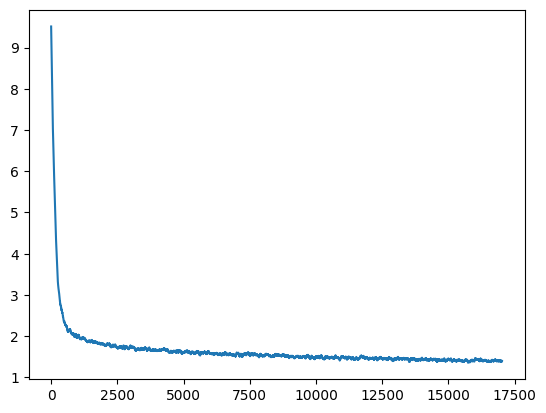

In [ ]:
window_size = 50
smoothed_losses = []
for i in range(len(losses)-window_size):
  smoothed_losses.append(np.mean(losses[i:i+window_size]))

plt.plot(smoothed_losses[100:])

In [ ]:
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [ ]:
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

In [ ]:
test_sentence = "त्या वेळचा तो काळ होता."
print('Raw input text:', test_sentence)

input_ids = encode_input_string(
    text = test_sentence,
    tokenizer = tokenizer,
    seq_len = model.config.max_length)
input_ids = input_ids.unsqueeze(0).cuda()
# input_ids = input_ids.unsqueeze(0)

print('Truncated input text:', tokenizer.convert_tokens_to_string(
    tokenizer.convert_ids_to_tokens(input_ids[0])))

Raw input text: त्या वेळचा तो काळ होता.
Truncated input text: त्या वेळचा तो काळ होता.</s><pad><pad><pad><pad><pad><pad><pad><pad><pad>


In [ ]:
output_tokens = model.generate(input_ids, num_beams=10, num_return_sequences=3, max_new_tokens=20)
# print(output_tokens)
for token_set in output_tokens:
  print(tokenizer.decode(token_set, skip_special_tokens=True))

That was the time of that time.
That was the time at that time.
It was the time of that time.


**Entry into Excel**

In [ ]:
lines = pd.read_excel("/content/comparisons.xlsx")
lines.head()

,Marathi,Actual,Predicted
0,खर्च कोण करणार,who is paying the price,who will do it
1,अधिवेशनातील कार्यक्रम,schedule of the conference,schedule of the programme
2,मायलिनला धक्का पोहोचल्याचा परिणाम मेंदूकडून शर...,abel himself then throws varlams corpse off a...,later on the other hand ordination was endowe...
3,इतका खंबीरपणा कुठुन मिळवला असेल त्याने,where does he get this kind of audacity,how did this game come from
4,हा महोत्सव सर्वांसाठी विनामूल्य ठेवण्यात आला आहे,the event is free for all,the programme is free for all


In [ ]:
m = lines["Marathi"]
trans = []

In [ ]:
for line in m:

  input_ids = encode_input_string(
    text = line,
    tokenizer = tokenizer,
    seq_len = model.config.max_length)
  input_ids = input_ids.unsqueeze(0).cuda()
  output_tokens = model.generate(input_ids, num_beams=10, num_return_sequences=3, max_new_tokens=20)

  for token_set in output_tokens:
    trans.append(tokenizer.decode(token_set, skip_special_tokens=True))
    break
  break


In [ ]:
print(trans)

['Today, ASEAN and India are going to promote multi-faceted coordination ']


In [ ]:
lines["T5-Prediction"] = trans

In [ ]:
lines.head()

,Marathi,Actual,Predicted,T5-Prediction
0,खर्च कोण करणार,who is paying the price,who will do it,Who will spend the expenses?
1,अधिवेशनातील कार्यक्रम,schedule of the conference,schedule of the programme,The event was attended by representatives of t...
2,मायलिनला धक्का पोहोचल्याचा परिणाम मेंदूकडून शर...,abel himself then throws varlams corpse off a...,later on the other hand ordination was endowe...,"As a result of a cardiac arrest, the brain bec..."
3,इतका खंबीरपणा कुठुन मिळवला असेल त्याने,where does he get this kind of audacity,how did this game come from,He knew where to find such a kind of courage.
4,हा महोत्सव सर्वांसाठी विनामूल्य ठेवण्यात आला आहे,the event is free for all,the programme is free for all,This festival is free for all.


In [ ]:
lines.to_excel("/content/drive/MyDrive/My ML Project /Translation/en-mr/comparisons2.xlsx", index=False)

BLEU Score Calculation

In [ ]:
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import pandas as pd

In [ ]:
actual = list(lines['Actual'])
predicted = list(lines['Predicted'])

In [ ]:
actual = list(lines['Actual'])
predicted = list(lines['T5-Prediction'])

actual_tokens = [sentence.split() for sentence in actual]
predicted_tokens = [sentence.split() for sentence in predicted]

total_bleu_score = 0
count = 0
for i in range(len(actual)):
  ref = actual[i].split()
  pred = predicted[i].split()
  if len(ref)>=4 and len(pred)>=4:
    bleu_score = sentence_bleu([ref], pred)
    print(bleu_score, ' '.join(ref)," | ", ' '.join(pred))
    total_bleu_score += bleu_score
    count+=1


average_bleu_score = total_bleu_score / count

print("Average BLEU Score:", average_bleu_score, count)

1.2183324802375697e-231 who is paying the price  |  Who will spend the expenses?
4.829607837557235e-155 schedule of the conference  |  The event was attended by representatives of the Ministry of Health and Family Welfare
9.151982895972797e-232 abel himself then throws varlams corpse off a cliff on the outskirts of the town  |  As a result of a cardiac arrest, the brain becomes a
6.373704167435469e-155 where does he get this kind of audacity  |  He knew where to find such a kind of courage.
5.775353993361614e-78 the event is free for all  |  This festival is free for all.
7.61581178815304e-232 besides providing stateoftheart facility this terminal will now be able to handle more passengers  |  Along with this project, the government has already started the project.
1.0016022933125248e-231 the health condition of goa chief minister manohar parrikar has deteriorated  |  Mumbai: Bharatiya Janata Party (BJP) chief Manohar Parrikar has
1.331960397810445e-231 all this has worried the local p